In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import json
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
import seaborn as sns
import numpy as np
import random
from sklearn import svm

sns.set_style("darkgrid")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Kaggle project from https://www.kaggle.com/rhammell/ships-in-satellite-imagery/data

These images are extracted from Planet satellite imagery. It includes 4000 80 x 80 RGB images with a label (ship or no-ship)


*   Labels: 1 for ship, 0 for no-ship
*   Scene_id : Identifier of teh PlanetScope visual scene from whigh the image was extacted.
*   Latitude Longitude

The dataset is also available as a JSON file that contains data, label, scene_ids and locations.
The pixel value for each 80x80 RGB image is stored as a list of 19200 integers. The first 6400 contain the red channel, then the green and finally the blue. The first entries of the array represent the first row of the image (the image is stored in row order)

For ships, there are about 1000 images in different offsets of the image, in different sizes and orientations and atmospheric conditions are included.

The rest 3000 no-ship class includes water, vegetation, earth building AND partial ships (about 1/3 of these 3000 images are partial ships) so it means that in the image you can see part of a ship but not enough to be granted the definition of ship.

## Aux Functions

In [0]:
def plot_some_rgb_images(to_plot, size_x, size_y, data, label, lim_red, lim_green, lim_blue):
    
    '''
    Do a RGB plot of our images
    to_plot : list of index in data file to plot
    size_x: number of pixels in x (len of side)
    size_y: same as size_x but for y
    lim_red = limiting pixel value that contains the red pixels (assuming R goes 0 to lim_red)
    lim_green = limiting pixel value that contains green pixels (assuming G goes from lim_red to lim_green)
    lim_blue = limiting pixel value that contains blue pixels (assuming B goes from lim_green to lim_blue)
    '''
    
    
    for ship in to_plot:
    
        ship_red = (np.array(data[ship][0:lim_red])).reshape([size_x,size_y])
        ship_green = (np.array(data[ship][lim_red:lim_green])).reshape([size_x,size_y])
        ship_blue = (np.array(data[ship][lim_green:lim_blue])).reshape([size_x,size_y])

        
        fig = plt.figure(figsize=(10,5), facecolor='white')
        plt.title('Label '+str(label[ship])+' Ship '+str(ship), y = 1.08)
        plt.axis('off')
        plt.set_cmap('jet')
        
        
        ax_red = fig.add_subplot(2,3,1)
        ax_green = fig.add_subplot(2,3,2)
        ax_blue = fig.add_subplot(2,3,3)
        
        ax_red_hist = fig.add_subplot(2, 3, 4)
        ax_green_hist = fig.add_subplot(2, 3, 5)
        ax_blue_hist = fig.add_subplot(2, 3, 6)
        
        ax_red.imshow(ship_red)
        ax_red.set_title('Red')
        ax_red_hist.hist(ship_red.flatten(), color='red')
        ax_red_hist.set_yticks([5000, 3000, 1000, 0])
        
        ax_green.imshow(ship_green)
        ax_green.set_title('Green')
        ax_green_hist.hist(ship_green.flatten(), color='green')
        ax_green_hist.set_yticks([5000, 3000, 1000, 0])
        
        ax_blue.imshow(ship_blue)
        ax_blue.set_title('Blue')
        ax_blue_hist.hist(ship_blue.flatten(), color='blue')
        ax_blue_hist.set_yticks([5000, 3000, 1000, 0])
        
        
    plt.tight_layout()


In [0]:
def plot_confusion_matrix(yreal, ypredicted):
    """
    As its name suggests, given the real value for y and the predicted value from our model 
    it plots the confusion matrix
    
    """
    
    cm = confusion_matrix(yreal, ypredicted)
    df_cm = pd.DataFrame(cm, index = [i for i in [0,1]],
                      columns = [i for i in [0,1]])

    plt.figure(figsize = (10,7))
    sns.set(font_scale=1.5)

    ax = sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='4.1f', annot_kws={'fontsize':15})


    plt.ylabel('Real Label', fontsize=17)
    plt.xlabel('Predicted Label', fontsize=17)
    plt.xticks(fontsize=17)
    plt.yticks(fontsize=17)

In [0]:
def roc_curve_plot(xtoplot, ytoplot, model, for_title):
    """
    Given a specific model that you are working with 
    plot the ROC curve and calculate AUC
    """

    # roc comparing all models not just for each separately
    probs = model.predict_proba(xtoplot)
    preds = probs[:,1]
    fpr, tpr, threshold = roc_curve(ytoplot, preds)
    roc_auc_model = auc(fpr, tpr)
    
    plt.figure(figsize=(12,8)) 
    plt.title('Receiver Operating Characteristic '+for_title)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_model)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

### Load JSON data

In [0]:
with open('shipsnet.json') as jsonfile:
    file_data = json.load(jsonfile)
jsonfile.close()    

In [0]:
data = file_data['data']
labels = file_data['labels']

In [26]:
type(data), len(data), len(data[1])

(list, 4000, 19200)

The variable data now contains a list of lists where each list is the unrolled RGB pixels of each image.

## Visualize some images

In [28]:
ships_index = [i for i in np.arange(0, len(labels)-1) if labels[i]==1]
noship_index = [j for j in np.arange(0, len(labels)-1) if labels[j]==0]

random_seed = 42
rand_ships = random.choices(ships_index, k=3)
rand_noship = random.choices(noship_index, k=3)

rand_ships, rand_noship

([634, 802, 323], [2221, 1125, 1543])

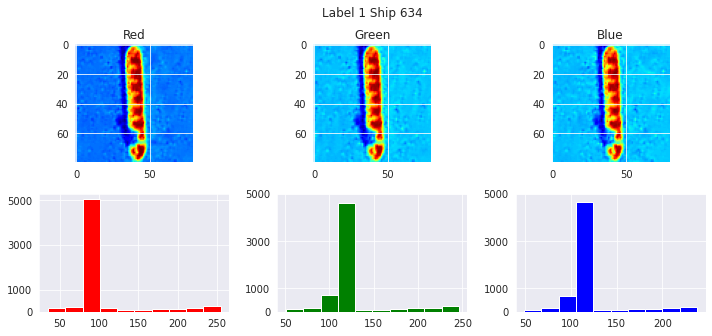

In [29]:
plot_some_rgb_images([rand_ships[0]], size_x=80, size_y=80, data=data, label=labels, lim_red=6400, lim_green=12800, lim_blue=19200)

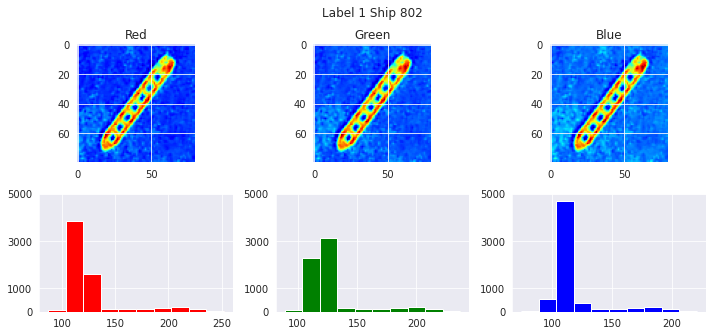

In [30]:
plot_some_rgb_images([rand_ships[1]], size_x=80, size_y=80, data=data, label=labels, lim_red=6400, lim_green=12800, lim_blue=19200)

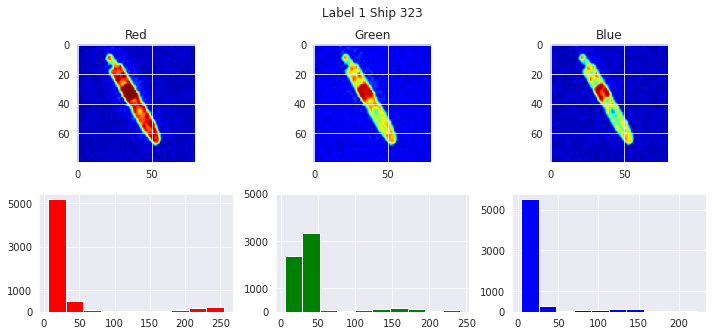

In [31]:
plot_some_rgb_images([rand_ships[2]], size_x=80, size_y=80, data=data, label=labels, lim_red=6400, lim_green=12800, lim_blue=19200)

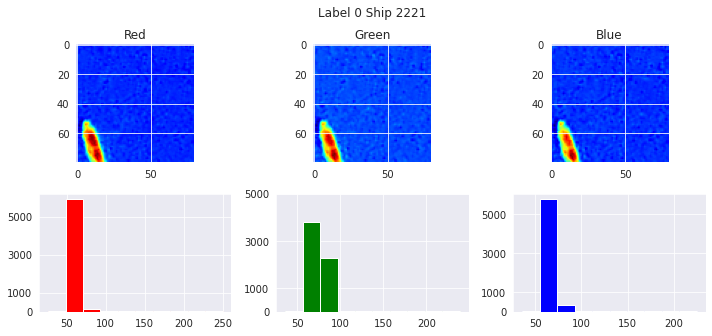

In [32]:
plot_some_rgb_images([rand_noship[0]], size_x=80, size_y=80, data=data, label=labels, lim_red=6400, lim_green=12800, lim_blue=19200)

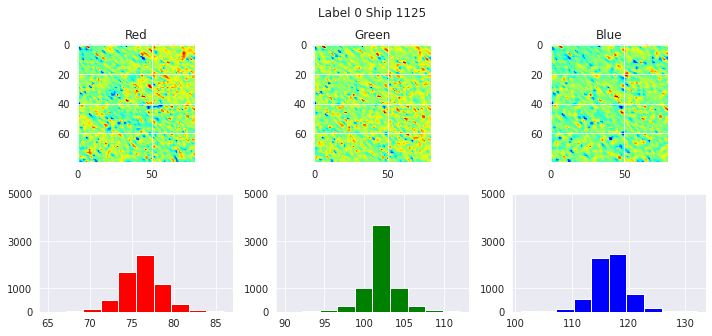

In [33]:
plot_some_rgb_images([rand_noship[1]], size_x=80, size_y=80, data=data, label=labels, lim_red=6400, lim_green=12800, lim_blue=19200)

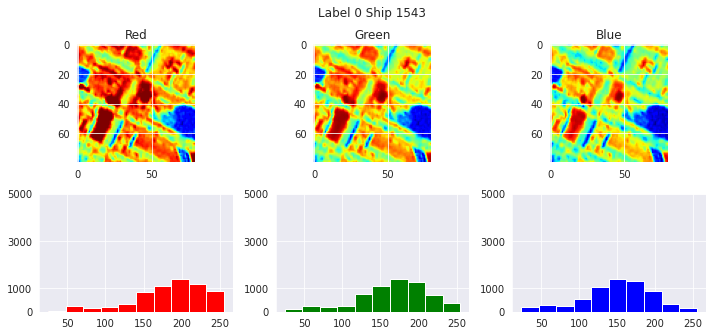

In [34]:
plot_some_rgb_images([rand_noship[2]], size_x=80, size_y=80, data=data, label=labels, lim_red=6400, lim_green=12800, lim_blue=19200)

In [35]:
rand_ships, rand_noship

([634, 802, 323], [2221, 1125, 1543])

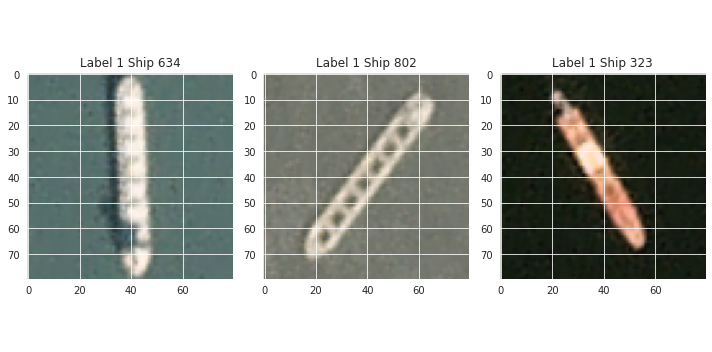

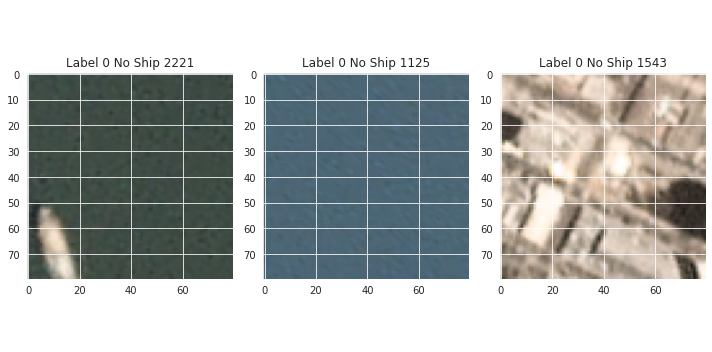

In [36]:
test = np.copy(data)
test_reshaped = test.reshape([-1,3,80,80]).transpose([0,2,3,1])
i = 1

fig = plt.figure(figsize=(10,5), facecolor='white')
plt.axis('off')

for iship in rand_ships:
        
        ax = fig.add_subplot(1,3,i)
        
        ax.imshow(np.reshape(test_reshaped[iship], (80, 80,3)), cmap=plt.cm.binary)
        ax.set_title('Label '+str(labels[iship])+' Ship '+str(iship))
        i = i + 1

plt.tight_layout()

fig = plt.figure(figsize=(10,5), facecolor='white')
plt.axis('off')

j = 1

for noship in rand_noship:
        
        ax = fig.add_subplot(1,3,j)
        
        ax.imshow(np.reshape(test_reshaped[noship], (80, 80,3)), cmap=plt.cm.binary)
        ax.set_title('Label '+str(labels[noship])+' No Ship '+str(noship))
        j = j + 1

plt.tight_layout()


## Normalization

In [37]:
test.shape, test_reshaped.shape

((4000, 19200), (4000, 80, 80, 3))

In [38]:
len(data), type(data), len(data[99]), np.max(data)

(4000, list, 19200, 255)

In [0]:
X = np.array(data)/255.0
y = np.array(labels)

## Training, Validation and Test Sets

In [40]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=7)
Xtrain, Xval, ytrain, yval = train_test_split(Xtrain, ytrain, test_size=0.1, random_state=7)

Xtrain.shape, Xtest.shape, Xval.shape

((2520, 19200), (1200, 19200), (280, 19200))

To begin our modelling, I will first use more conventional approaches like XGBoost, Random Forest and SVM before I move on to Convolutional Neural Networks.

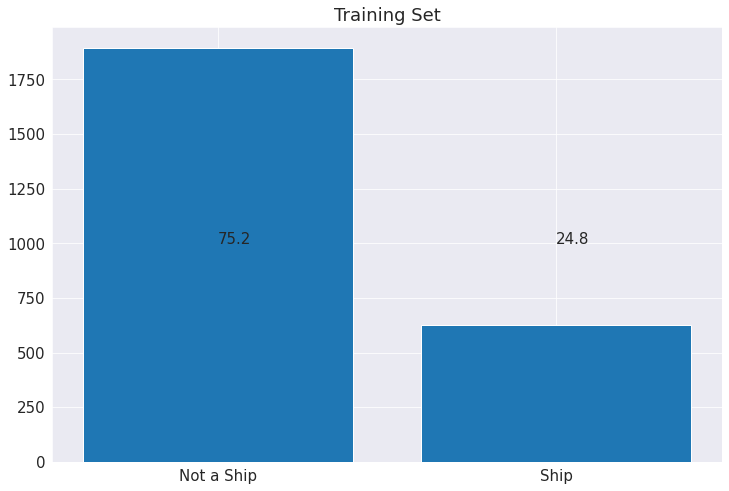

In [41]:
len_targets = [len(ytrain[ytrain==0]), len(ytrain[ytrain==1])]

plt.figure(figsize=(12,8), facecolor='white')
plt.bar(['0', '1'], len_targets)
plt.xticks([0,1], ('Not a Ship', 'Ship'), fontsize=15)
plt.yticks(fontsize=15)
_ = plt.text(0, 1000, round(len_targets[0]/len(ytrain)*100,2), fontsize=15)
_ = plt.text(1, 1000, round(len_targets[1]/len(ytrain)*100,2), fontsize=15)
_ = plt.title('Training Set', fontsize=18)

## XGBoost base model

In [42]:
xg = xgb.XGBClassifier()
xg.fit(Xtrain, ytrain)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [43]:
y_xgbase = xg.predict(Xval)
print(classification_report(yval, y_xgbase))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       208
           1       0.90      0.90      0.90        72

    accuracy                           0.95       280
   macro avg       0.93      0.93      0.93       280
weighted avg       0.95      0.95      0.95       280



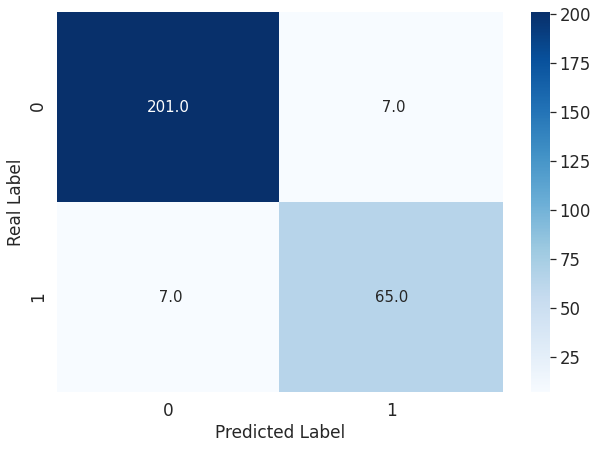

In [98]:
plot_confusion_matrix(yval, y_xgbase)

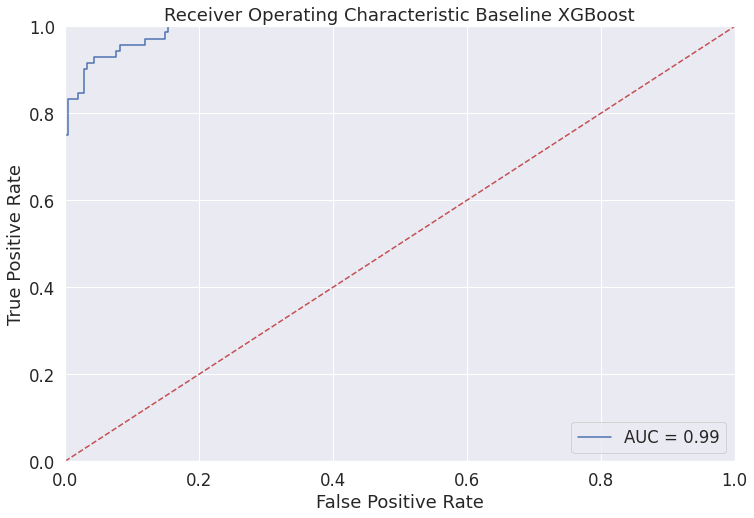

In [45]:
roc_curve_plot(Xval, yval, xg, 'Baseline XGBoost')

It is interesting to see that even a baseline XGBoost doesn't do too bad. Where did it go wrong? What images did it fail to properly classify as ships?

In [46]:
xb_base_results = np.c_[Xval, yval, y_xgbase]
xb_base_results.shape

(280, 19202)

In [47]:
np.unique(xb_base_results[:,19201]), np.unique(xb_base_results[:,19200])

(array([0., 1.]), array([0., 1.]))

In [48]:
wrong_xgbase = xb_base_results[xb_base_results[:,19200]!=xb_base_results[:,19201]]
wrong_xgbase.shape

(14, 19202)

In [49]:
wrong_xgbase[:,19200], wrong_xgbase[:,19201], wrong_xgbase[1,19200], wrong_xgbase[1,19201]

(array([0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.]),
 array([1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0.]),
 0.0,
 1.0)

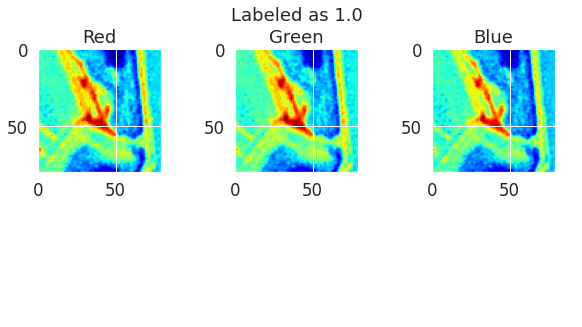

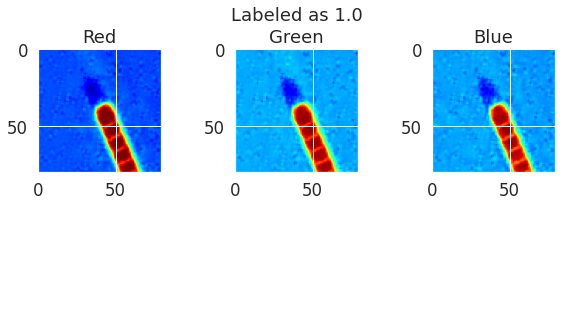

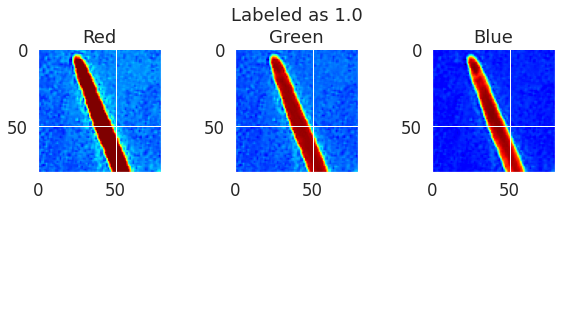

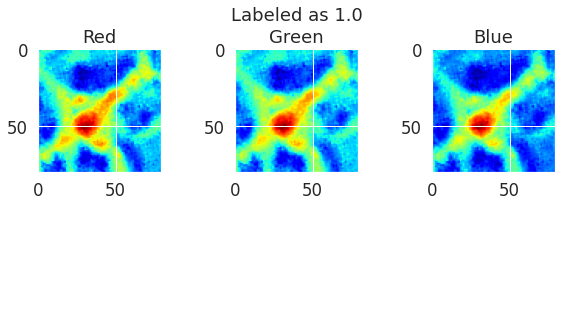

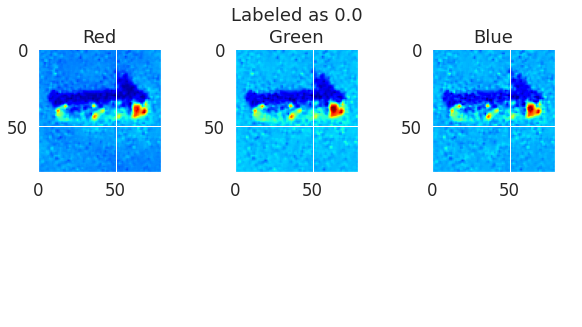

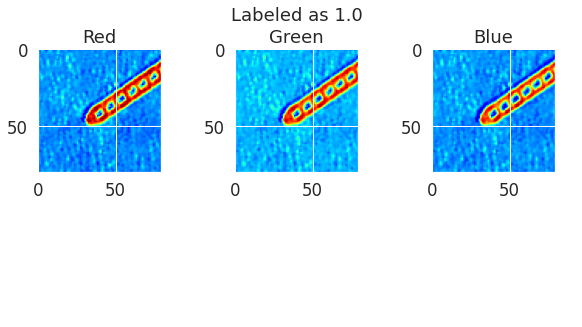

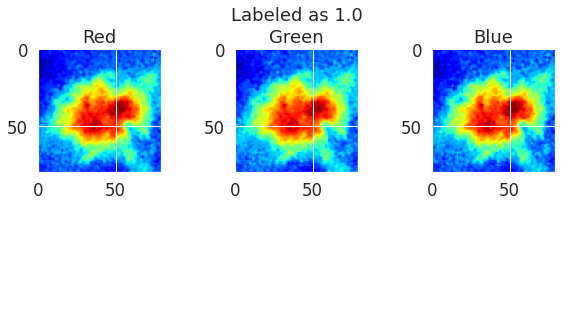

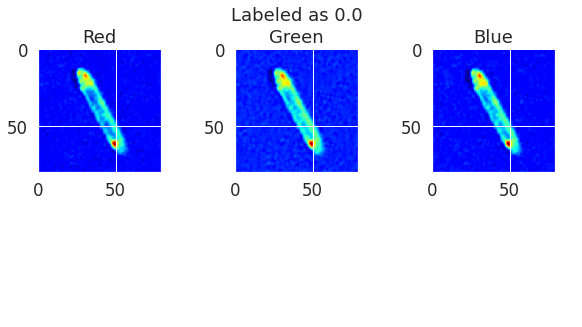

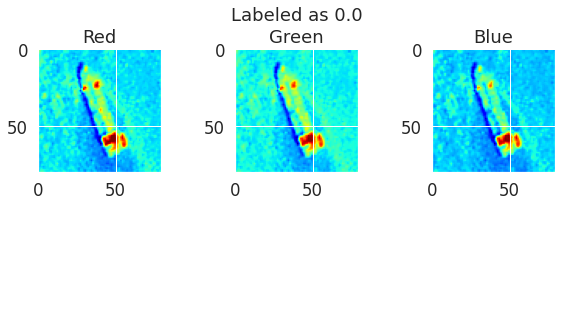

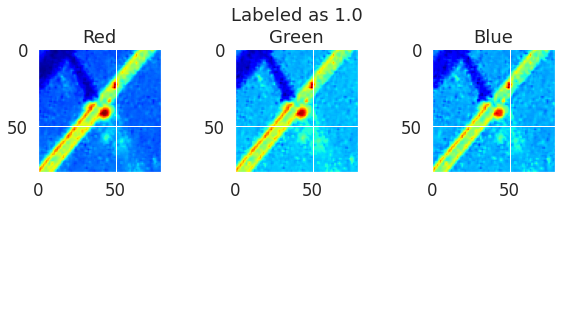

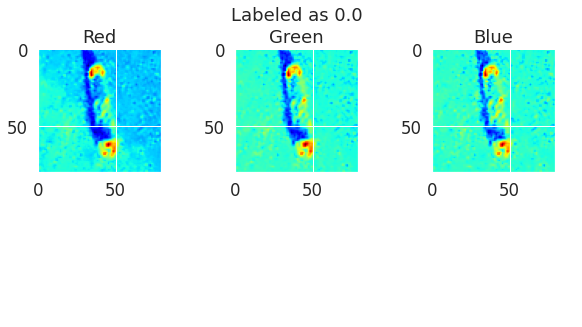

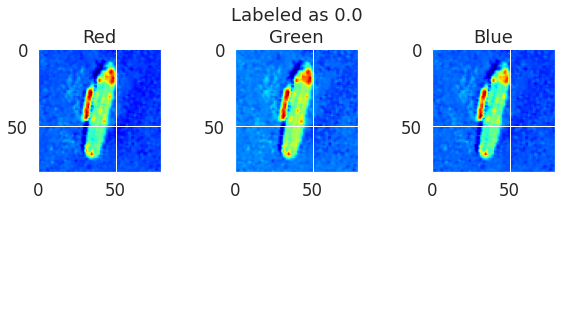

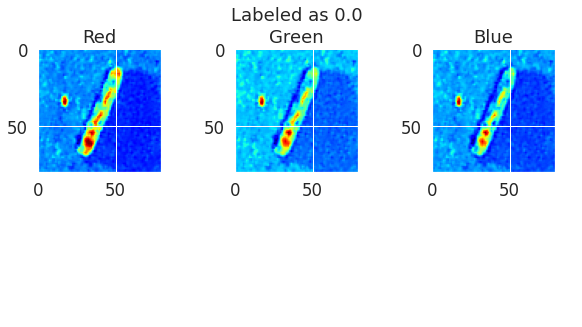

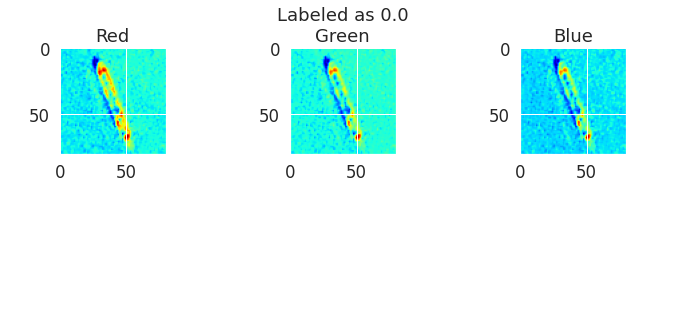

In [50]:
for mk in wrong_xgbase:

        ship_red = (np.array(mk[0:6400])).reshape([80,80])
        ship_green = (np.array(mk[6400:12800])).reshape([80,80])
        ship_blue = (np.array(mk[12800:19200])).reshape([80,80])
        
        fig = plt.figure(figsize=(10,5))
        
        plt.axis('off')
        plt.set_cmap('jet')
        plt.title('Labeled as '+str(mk[19201]), y = 1.08)
        
        
        ax_red = fig.add_subplot(2,3,1)
        ax_green = fig.add_subplot(2,3,2)
        ax_blue = fig.add_subplot(2,3,3)
        
        ax_red.imshow(ship_red)
        ax_red.set_title('Red')
        
        ax_green.imshow(ship_green)
        ax_green.set_title('Green')

        
        ax_blue.imshow(ship_blue)
        ax_blue.set_title('Blue')
        
plt.tight_layout()

Looking at the images that have been mis-classified we can see several cases where it doesn't do well:
1. Images with a bright concentrated object: misclassified as being a ship
2. Ships with not normal sizes are misclassified.
3. Bright streaks are classified as ships
4. Ships with companion smaller ships are misclassified
5. Some partial ships are classified as ships (I expect neural networks will do much better in these cases)

It is clear that we need to increase the complexity of our model

Before trying CNNs I will try SVM with a RBF Kernel (I am skipping the LinearSVM because we assume this is not a linear problem).

## Gaussian RBF Kernel SVM

* gamma = acts like a regularization parameter, increasing gamma makes the gaussian narrower, so each instance's range of influence is smaller. (Remember is the coefficient to multiply after you have calculated the square distance to the landmark)

* C = also acts as a regularization parameter. If your model is overfitting, reduce C.

In [0]:
svm_model = svm.SVC(kernel='rbf')

In [52]:
svm_model.fit(Xtrain, ytrain)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [53]:
y_svmrbf = svm_model.predict(Xval)
print(classification_report(yval, y_svmrbf))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       208
           1       0.94      0.92      0.93        72

    accuracy                           0.96       280
   macro avg       0.96      0.95      0.95       280
weighted avg       0.96      0.96      0.96       280



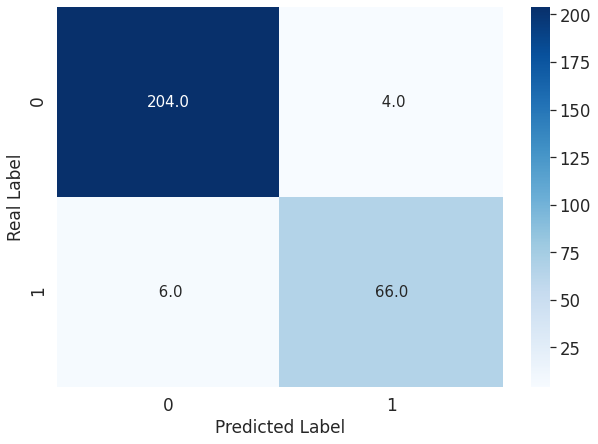

In [54]:
plot_confusion_matrix(yval, y_svmrbf)

In [55]:
svm_base_results = np.c_[Xval, yval, y_svmrbf]
wrong_svmbase = svm_base_results[svm_base_results[:,19200]!=svm_base_results[:,19201]]
wrong_svmbase.shape

(10, 19202)

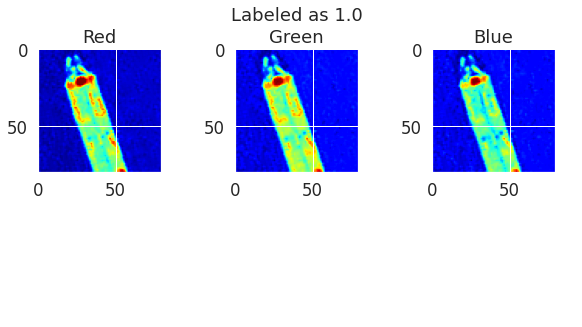

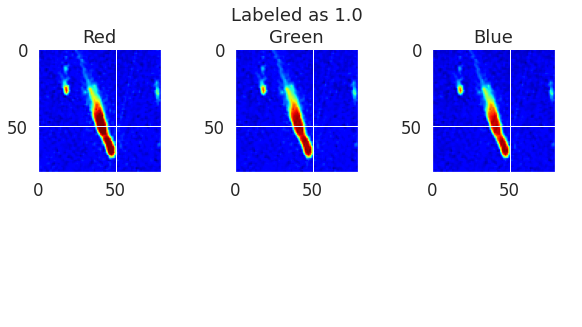

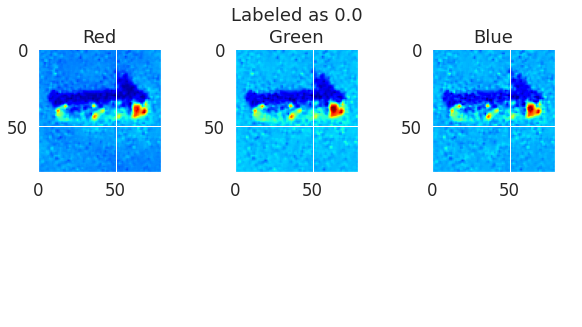

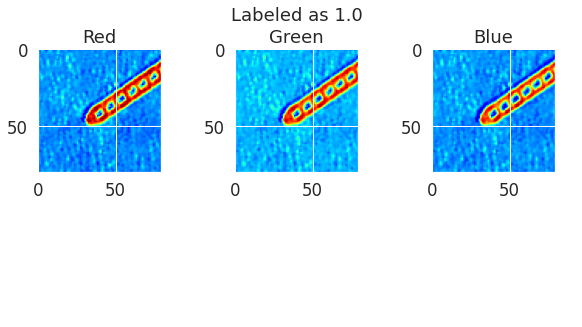

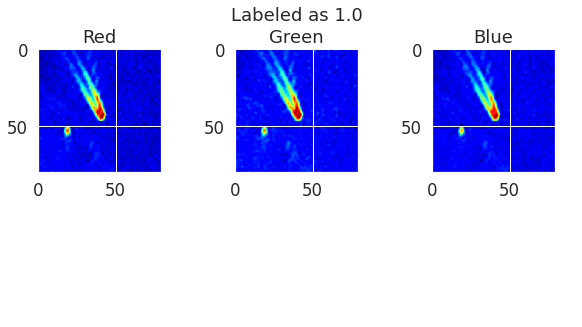

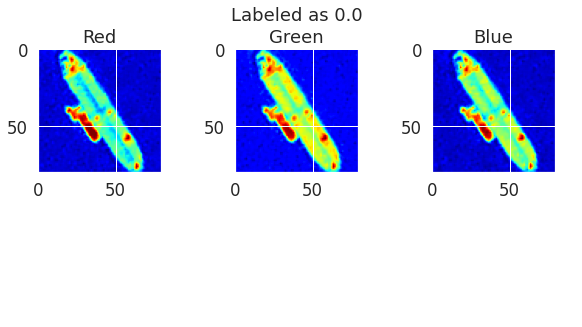

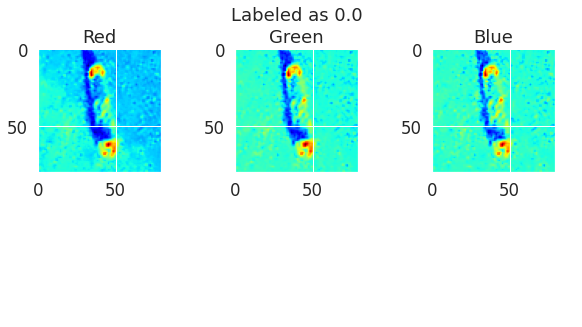

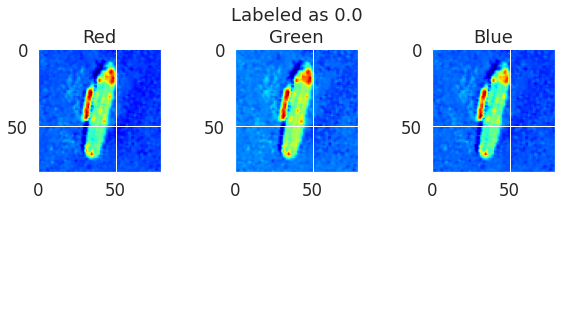

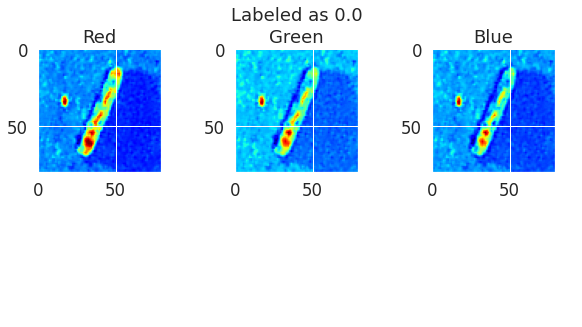

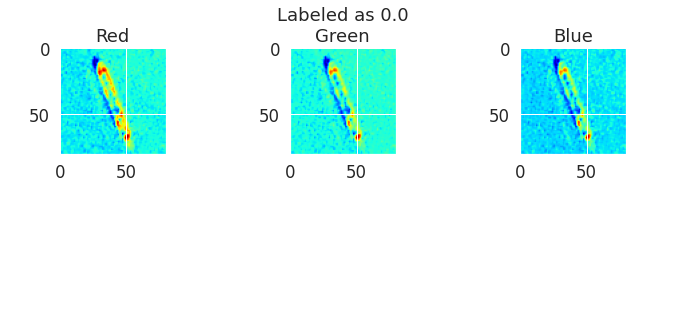

In [56]:
for mk in wrong_svmbase:

        ship_red = (np.array(mk[0:6400])).reshape([80,80])
        ship_green = (np.array(mk[6400:12800])).reshape([80,80])
        ship_blue = (np.array(mk[12800:19200])).reshape([80,80])
        
        fig = plt.figure(figsize=(10,5))
        
        plt.axis('off')
        plt.set_cmap('jet')
        plt.title('Labeled as '+str(mk[19201]), y = 1.08)
        
        
        ax_red = fig.add_subplot(2,3,1)
        ax_green = fig.add_subplot(2,3,2)
        ax_blue = fig.add_subplot(2,3,3)
        
        ax_red.imshow(ship_red)
        ax_red.set_title('Red')
        
        ax_green.imshow(ship_green)
        ax_green.set_title('Green')

        
        ax_blue.imshow(ship_blue)
        ax_blue.set_title('Blue')
        
plt.tight_layout()

## CNNs
* RE-shape images 
* Add sequential, convolution, maxpool
* Think about all the activation functions
* NN

In [57]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten
 

Using TensorFlow backend.


In [58]:
# current shape
Xtrain.shape, Xtest.shape, Xval.shape

((2520, 19200), (1200, 19200), (280, 19200))

### Re-shaping
To understand re-shaping I will take a test sample and work with it.

Conv2D expects 4 dimensions (BatchSize, Channel, Width, Height)

In [59]:
test_image = Xtrain[99]
test_image.shape

(19200,)

In [60]:
test_reshaped = test_image.reshape([3,80,80])
test_reshaped.shape, type(test_reshaped)

((3, 80, 80), numpy.ndarray)

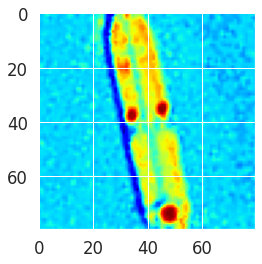

In [61]:
 plt.imshow(test_reshaped[1])

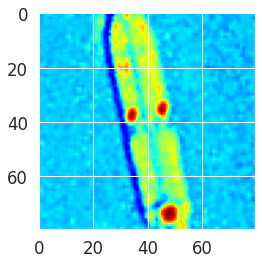

In [62]:
plt.imshow(test_reshaped[2])

However, we need a 4D Tensor as input

In [0]:
test_2reshaped = test_image.reshape([1,3,80,80])

In [64]:
test_2reshaped.shape

(1, 3, 80, 80)

In [65]:
test_2reshaped = test_2reshaped.transpose([0,2,3,1]) # BATCH_SIZE, WIDTH, HEIGHT, CHANNELS
test_2reshaped.shape

(1, 80, 80, 3)

In [66]:
Xtrain_rsp = Xtrain.reshape([-1,3,80,80]).transpose([0,2,3,1])
Xtest_rsp = Xtest.reshape([-1,3,80,80]).transpose([0,2,3,1])
Xval_rsp = Xval.reshape([-1,3,80,80]).transpose([0,2,3,1])


Xtrain.shape, Xtrain_rsp.shape, Xtest_rsp.shape, Xval_rsp.shape

((2520, 19200), (2520, 80, 80, 3), (1200, 80, 80, 3), (280, 80, 80, 3))

### Hyperparameter Tunning in NN

* Number of Layers: Often times, complex problems can be resolved with high accuracy with just a single hidden layer. However, more complex problems require several layers where we can take advantage of the fact that the lower hidden layers model low-level structures, intermediate hidden layers take those low level structures and model intermediate-level ones and so on until we can model high level structures with high hidden layers.

In practice, we can start with a couple hidden layers and increase until our model starts to overfit.

* Number of neurons per hidden layer: It is usually better to incrase the number of layers than the number of neurons in each layer. In general, we can increase the number of units until we start overfitting or implement early stopping. However, a low number of units will stop you from getting a good representation.


In [0]:

model = tf.keras.models.Sequential([

    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=((80,80,3))),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=((80,80,3))),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=((80,80,3))),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [68]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 78, 78, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 39, 39, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 37, 37, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 18, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0

In [0]:
model.compile(loss='sparse_categorical_crossentropy', optimizer = 'Adam' , metrics=['accuracy'])

In [70]:
Xtrain_rsp.shape, Xval_rsp.shape

((2520, 80, 80, 3), (280, 80, 80, 3))

When training, we can also establish a desired accuracy and use callbacks.Callback to stop training once we have reached a desired accuracy.

I have not implemented it here for this model but this is an excelent resource to see its implementation: [Intro to TF](https://www.coursera.org/learn/introduction-tensorflow/home/week/2)

In [71]:
epoch = 30
history = model.fit(Xtrain_rsp, ytrain, epochs=epoch, validation_data=(Xval_rsp, yval))

Epoch 1/30
79/79 [==============================] - 17s 217ms/step - loss: 0.4258 - accuracy: 0.8171 - val_loss: 0.2844 - val_accuracy: 0.8857
Epoch 2/30
79/79 [==============================] - 17s 213ms/step - loss: 0.2252 - accuracy: 0.9024 - val_loss: 0.2121 - val_accuracy: 0.9000
Epoch 3/30
79/79 [==============================] - 17s 214ms/step - loss: 0.1528 - accuracy: 0.9385 - val_loss: 0.1867 - val_accuracy: 0.9250
Epoch 4/30
79/79 [==============================] - 17s 213ms/step - loss: 0.1176 - accuracy: 0.9552 - val_loss: 0.1546 - val_accuracy: 0.9357
Epoch 5/30
79/79 [==============================] - 17s 213ms/step - loss: 0.0726 - accuracy: 0.9758 - val_loss: 0.1549 - val_accuracy: 0.9429
Epoch 6/30
79/79 [==============================] - 17s 211ms/step - loss: 0.0793 - accuracy: 0.9671 - val_loss: 0.2060 - val_accuracy: 0.9571
Epoch 7/30
79/79 [==============================] - 17s 213ms/step - loss: 0.0468 - accuracy: 0.9825 - val_loss: 0.1117 - val_accuracy: 0.9714

In [72]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

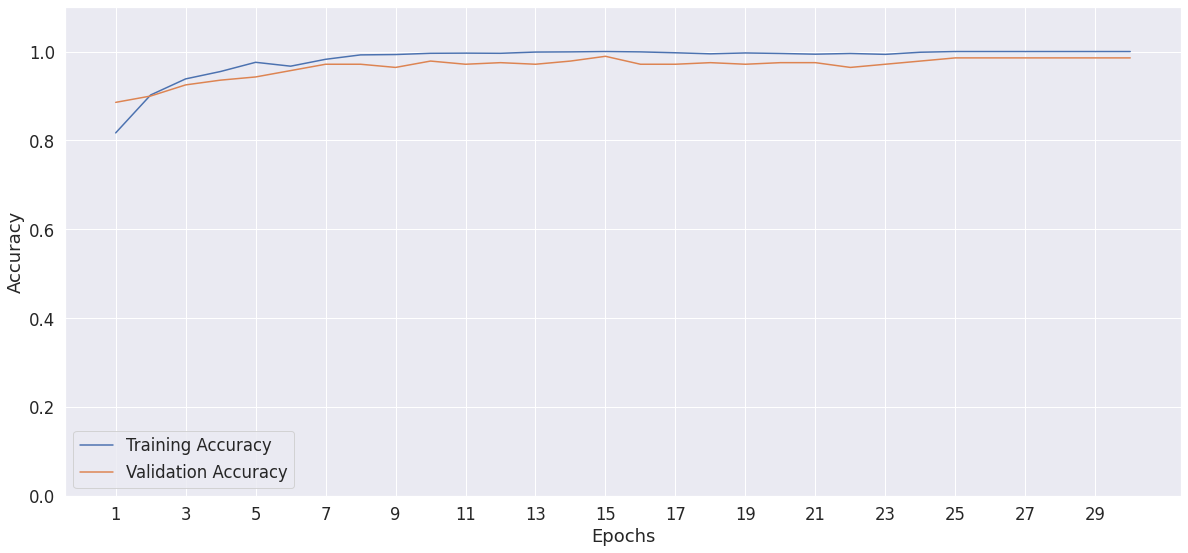

In [73]:
train_acc = pd.DataFrame(history.history['accuracy'])
val_acc = pd.DataFrame(history.history['val_accuracy'])

ep = np.arange(1, epoch+1, 1)

plt.figure(figsize=(20,9))
plt.plot(ep, train_acc, label='Training Accuracy')
plt.plot(ep, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(ep[::2])
plt.grid(True)
plt.gca().set_ylim(0,1.1)
plt.legend()
plt.show()

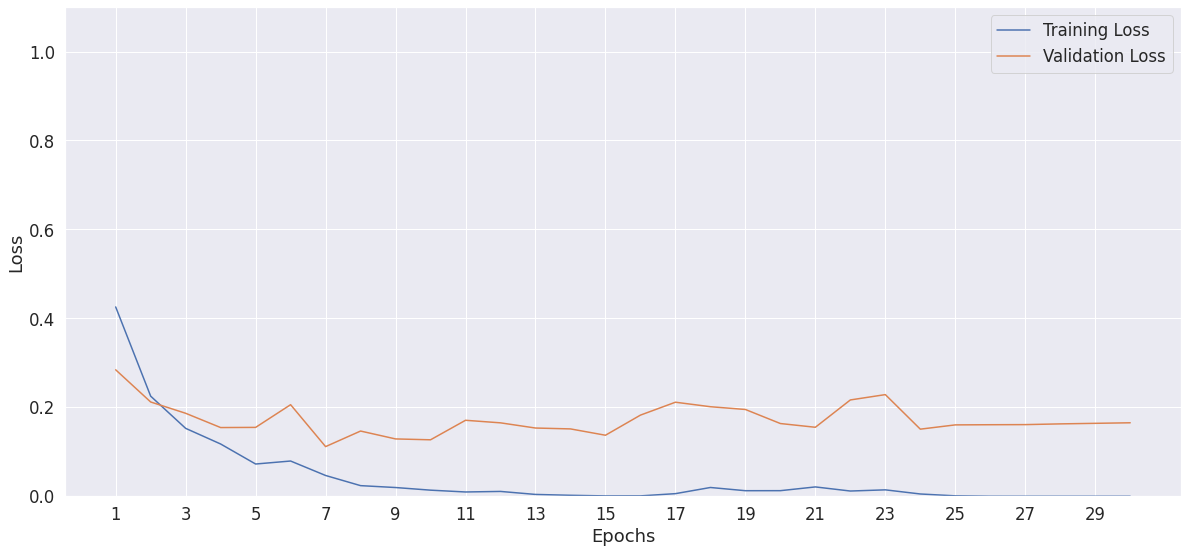

In [74]:
train_loss = pd.DataFrame(history.history['loss'])
val_loss = pd.DataFrame(history.history['val_loss'])


plt.figure(figsize=(20,9))
plt.plot(ep, train_loss, label='Training Loss')
plt.plot(ep, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(ep[::2])
plt.grid(True)
plt.gca().set_ylim(0,1.1)
plt.legend()
plt.show()

As we can see above the loss in the validation set is distinctly different that that of a training set. Normally, if the validation and training start to deviate from each other and we see some overfitting in our data, we can stop training at the min distance between the two.

Let's take a look at the classification report and confusion matrix for our validation set.

In [75]:
yval.shape

(280,)

In [0]:
y_nn = model.predict(Xval_rsp)
y_nnp = []

for item in y_nn:
  temp = -99

  litem = list(item)
  maxpos = litem.index(max(litem))
  pred_nnp = item[maxpos]


  y_nnp.append(maxpos)

In [77]:
y_nn[9], y_nnp[9]

(array([9.9999487e-01, 5.0706926e-06], dtype=float32), 0)

In [78]:
print(classification_report(yval, y_nnp))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       208
           1       0.97      0.97      0.97        72

    accuracy                           0.99       280
   macro avg       0.98      0.98      0.98       280
weighted avg       0.99      0.99      0.99       280



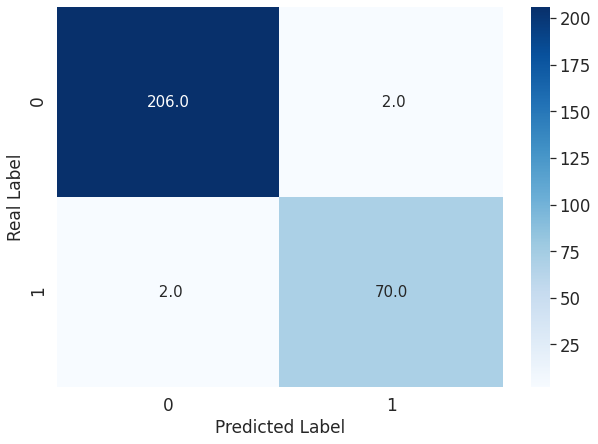

In [79]:
plot_confusion_matrix(yval, y_nnp)

As expected, CNN performed better than our previous classification methods, but it is still not perfect, before moving on to take a look at its perfomance on new and completely unseen data, let's take a look at which cases did it misclassify in the validation set.

In [88]:
cnn_results = np.c_[Xval, yval, y_nnp]
wrong_cnn = cnn_results[cnn_results[:,19200]!=cnn_results[:,19201]]
wrong_cnn.shape

(4, 19202)

In [90]:
wrong_cnn[:,19200:]

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.]])

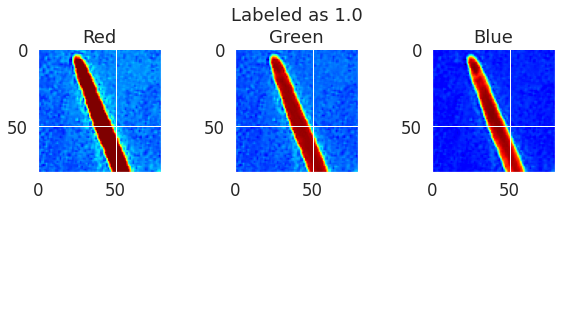

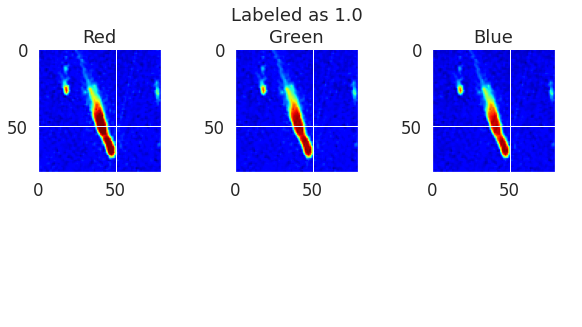

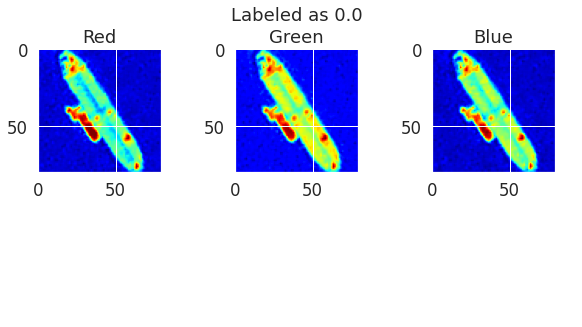

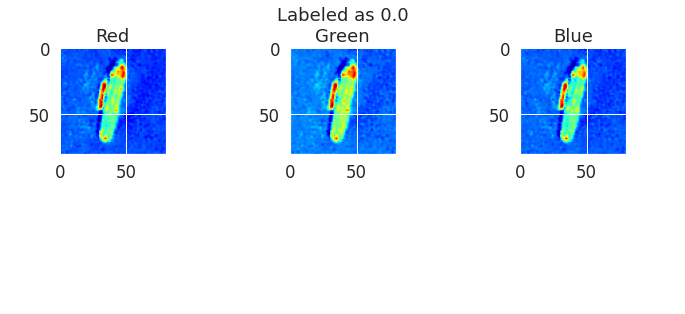

In [91]:
for mk in wrong_cnn:

        ship_red = (np.array(mk[0:6400])).reshape([80,80])
        ship_green = (np.array(mk[6400:12800])).reshape([80,80])
        ship_blue = (np.array(mk[12800:19200])).reshape([80,80])
        
        fig = plt.figure(figsize=(10,5))
        
        plt.axis('off')
        plt.set_cmap('jet')
        plt.title('Labeled as '+str(mk[19201]), y = 1.08)
        
        
        ax_red = fig.add_subplot(2,3,1)
        ax_green = fig.add_subplot(2,3,2)
        ax_blue = fig.add_subplot(2,3,3)
        
        ax_red.imshow(ship_red)
        ax_red.set_title('Red')
        
        ax_green.imshow(ship_green)
        ax_green.set_title('Green')

        
        ax_blue.imshow(ship_blue)
        ax_blue.set_title('Blue')
        
plt.tight_layout()

It is not unexpected to see that ships with a smaller ship on the side are hard to classify, we probably don't have enough training examples of this kind for the algorithm to make the right decision. 

On the other hand, long, elongated structures are still classified as ships

## Performance in test set

In [0]:
y_tnn = model.predict(Xtest_rsp)
y_tnnp = []

for item in y_tnn:
  temp = -99

  litem = list(item)
  maxpos = litem.index(max(litem)) #assign the label as the position with the highest probability
  pred_nnp = item[maxpos]


  y_tnnp.append(maxpos)

In [94]:
len(y_tnnp), type(y_tnnp), np.unique(y_tnnp)

(1200, list, array([0, 1]))

In [96]:
print(classification_report(ytest, y_tnnp))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       897
           1       0.98      0.97      0.97       303

    accuracy                           0.99      1200
   macro avg       0.98      0.98      0.98      1200
weighted avg       0.99      0.99      0.99      1200



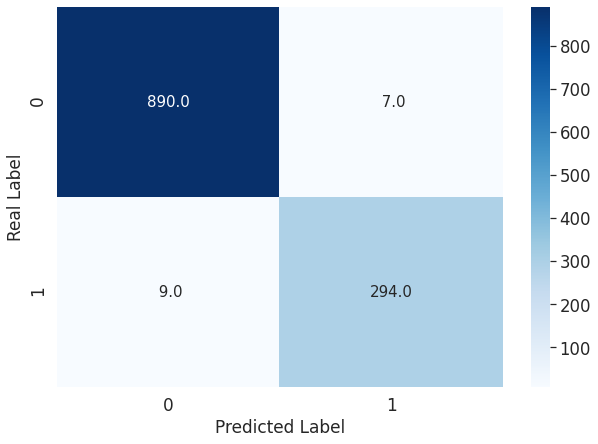

In [97]:
plot_confusion_matrix(ytest, y_tnnp)